In [ ]:
# pip install --upgrade category_encoders

# Import necessary libraries
import pandas as pd
import numpy as np
import string
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from gensim.models import Word2Vec
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

from sklearn.neighbors import KNeighborsClassifier

In [ ]:
# Load your dataset
vader_data = pd.read_csv('/content/coffee_VADER_sentiment_analysis_results.csv')

In [ ]:
# Check the range of values in the 'rating' column
rating_min = vader_data['rating'].min()
rating_max = vader_data['rating'].max()

print(f"Rating Range: {rating_min} to {rating_max}")

Rating Range: 84 to 98


In [ ]:
# Check the distribution of prices
print(vader_data['100g_USD'].describe())

count    2095.000000
mean        9.323313
std        11.430659
min         0.120000
25%         4.930000
50%         5.860000
75%         8.785000
max       132.280000
Name: 100g_USD, dtype: float64


In [ ]:
# Create buckets based on price ranges (adjust the ranges based on distribution)
vader_data['price_bucket'] = pd.cut(vader_data['100g_USD'], bins=[0, 10, 20, 30, 100], labels=['Low Price', 'Medium Price', 'High Price', 'Very High Price'])

# Check the new class distribution
print(vader_data['price_bucket'].value_counts())

price_bucket
Low Price          1660
Medium Price        258
High Price          102
Very High Price      67
Name: count, dtype: int64


In [ ]:
# Check the distribution of sentiment scores
print(vader_data['compound_scaled_1_10'].describe())

count    2095.000000
mean        8.868403
std         0.881559
min         4.589650
25%         8.691625
50%         9.156700
75%         9.474850
max         9.887500
Name: compound_scaled_1_10, dtype: float64


In [ ]:
# Create sentiment buckets based on sentiment score ranges
vader_data['sentiment_bucket'] = pd.cut(vader_data['compound_scaled_1_10'], bins=[0, 4, 7, 10], labels=['Low Sentiment', 'Neutral Sentiment', 'High Sentiment'])

# Check the new class distribution
print(vader_data['sentiment_bucket'].value_counts())

sentiment_bucket
High Sentiment       2011
Neutral Sentiment      84
Low Sentiment           0
Name: count, dtype: int64


In [ ]:
# Convert 'review_date' to datetime format
vader_data['review_date'] = pd.to_datetime(vader_data['review_date'])

# Extract year, month, and day as separate features
vader_data['review_year'] = vader_data['review_date'].dt.year
vader_data['review_month'] = vader_data['review_date'].dt.month
vader_data['review_day'] = vader_data['review_date'].dt.day

In [ ]:
vader_data = vader_data.drop(columns = ['desc_1', 'sentiment_scores', 'compound', 'compound_scaled_0_1', 'review_date'])

vader_copy = vader_data.copy()

In [ ]:
def clean_text(text):
    # Lowercase the text
    text = text.lower()
    # Remove standard punctuation using string.punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove curly quotes manually
    text = text.replace("“", "").replace("”", "").replace("‘", "").replace("’", "").replace("'", "").replace('"', "")
    return text

# Apply the updated cleaning function to the relevant columns
columns_to_clean = ['name', 'roaster', 'roast', 'loc_country', 'origin_1', 'origin_2']
for col in columns_to_clean:
    vader_data[col] = vader_data[col].apply(clean_text)

In [ ]:
# Tokenize the 'cleaned_desc_1' text
tokenized_texts = [desc.split() for desc in vader_data['cleaned_desc_1']]

In [ ]:
# Train a Word2Vec model on the tokenized text
word2vec_model = Word2Vec(sentences=tokenized_texts, vector_size=100, window=5, min_count=1, workers=4)

In [ ]:
# Function to average word vectors to create document vectors
def get_vector(text):
    words = text.split()
    vector = np.zeros(100)  # Same size as Word2Vec vector_size
    count = 0
    for word in words:
        if word in word2vec_model.wv.key_to_index:
            vector += word2vec_model.wv[word]
            count += 1
    if count > 0:
        vector /= count
    return vector

# Apply the function to create vectors for all descriptions
vader_data['doc_vector'] = vader_data['cleaned_desc_1'].apply(get_vector)

In [ ]:
# Convert list of vectors into a DataFrame
doc_vectors = np.array(vader_data['doc_vector'].tolist())

# Apply PCA to reduce dimensionality of the document vectors
pca = PCA(n_components=5)  # Reduce to 10 components
doc_vectors_pca = pca.fit_transform(doc_vectors)

In [ ]:
# Apply PCA to reduce dimensionality of the document vectors
pca = PCA(n_components=5)  # Reduce to 10 components
doc_vectors_pca = pca.fit_transform(doc_vectors)

# Convert PCA output to DataFrame and merge with original features
doc_vectors_df = pd.DataFrame(doc_vectors_pca, columns=[f'pc_{i+1}' for i in range(5)])
vader_data = pd.concat([vader_data.reset_index(drop=True), doc_vectors_df.reset_index(drop=True)], axis=1)

# Drop the 'cleaned_desc_1' and 'doc_vector' columns after PCA
vader_data = vader_data.drop(columns=['cleaned_desc_1', 'doc_vector'])

In [ ]:
# Standardize column names: convert to lowercase and replace spaces with underscores
vader_data.columns = vader_data.columns.str.lower().str.replace(' ', '_').str.replace('-', '_')

# If you want to ensure no special characters, you can use regex to remove them
vader_data.columns = vader_data.columns.str.replace(r'[^a-zA-Z0-9_]', '', regex=True)

In [ ]:
# Label encode categorical columns
label_columns = ['name', 'roaster', 'roast', 'loc_country', 'origin_1', 'origin_2']
label_encoder = LabelEncoder()
for col in label_columns:
    vader_data[col] = label_encoder.fit_transform(vader_data[col])

In [ ]:
# Apply StandardScaler to numerical features
scaler = StandardScaler()
numerical_features = ['rating', 'compound_scaled_1_10', 'pc_1', 'pc_2', 'pc_3', 'pc_4', 'pc_5']
vader_data[numerical_features] = scaler.fit_transform(vader_data[numerical_features])

In [ ]:
# Define features and target (Price)
X = vader_data[['compound_scaled_1_10', 'rating', 'roaster', 'origin_1', 'origin_2', 'pc_1', 'pc_2', 'pc_3', 'pc_4', 'pc_5', 'review_year', 'review_month', 'review_day']]
y = vader_data['100g_usd']  # Target: price

In [ ]:
# Define the categorical columns
categorical_columns = ['name', 'roaster', 'roast', 'loc_country', 'origin_1', 'origin_2']

# Check the number of unique values in each categorical column
unique_values = {col: vader_data[col].nunique() for col in categorical_columns}

# Display the number of unique values per categorical column
print(unique_values)

{'name': 1906, 'roaster': 414, 'roast': 5, 'loc_country': 19, 'origin_1': 612, 'origin_2': 349}


In [ ]:
# Create a copy of the dataframe to avoid modifying the original one
vader_data_encoded = vader_data.copy()

# Define the categorical columns to encode
categorical_columns = ['price_bucket', 'sentiment_bucket', 'roaster', 'origin_1', 'origin_2', 'name', 'roast', 'loc_country']

# Apply Label Encoding to each categorical column
label_encoder = LabelEncoder()

for col in categorical_columns:
    vader_data_encoded[col] = label_encoder.fit_transform(vader_data_encoded[col].astype(str))

In [ ]:
# Separate features (X) and target (y) - Example: Predicting price_bucket
X = vader_data_encoded.drop(columns=['price_bucket'])
y = vader_data_encoded['price_bucket']

In [ ]:
# Group roasters by their average rating
roaster_ratings = vader_copy.groupby('roaster')['rating'].mean().reset_index().sort_values(by='rating', ascending=False)
print("Roasters sorted by average rating:")
roaster_ratings.head(10)  # Top 10 roasters based on rating

Roasters sorted by average rating:


,roaster,rating
211,Kakalove Café,96.000
162,Genesis Coffee Lab,95.500
75,Campos Coffee,95.500
191,Hula Daddy Kona Coffee,95.125
307,RD Cafe,95.000
375,Taster’s Coffee,95.000
145,Felala Coffee Lab,95.000
350,Small Eyes Café,95.000
50,Boon Boona Coffee,95.000
338,San Francisco Bay Coffee Company,95.000


In [ ]:
# Group roasters by their average sentiment score (compound_scaled_1_10)
roaster_sentiment = vader_copy.groupby('roaster')['compound_scaled_1_10'].mean().reset_index().sort_values(by='compound_scaled_1_10', ascending=False)
print("Roasters sorted by average sentiment score:")
roaster_sentiment.head(10) # Top 10 roasters based on sentiment

Roasters sorted by average sentiment score:


,roaster,compound_scaled_1_10
268,Novo Coffee,9.88750
297,Portrait Coffee,9.81010
369,Sweet Bloom Coffee Roasters,9.80965
352,South Slope Coffee Roasters,9.80155
59,Cafe Arles,9.77905
10,Aether Coffee,9.75700
147,Fieldheads Coffee Roasting,9.74890
330,Rubasse Coffee Roaster,9.72685
196,JYL Cafe,9.72190
112,Detour Coffee Roasters,9.72145


In [ ]:
# Merge ratings and sentiment into one DataFrame to identify the top-performing roasters
best_roasters = pd.merge(roaster_ratings, roaster_sentiment, on='roaster')
best_roasters.columns = ['roaster', 'avg_rating', 'avg_sentiment']

In [ ]:
# Sort by highest ratings and sentiment scores
best_roasters = best_roasters.sort_values(by=['avg_rating', 'avg_sentiment'], ascending=False)
print("Top Roasters by both Rating and Sentiment:")
best_roasters.head(10)  # Top 10 roasters based on combined metrics

Top Roasters by both Rating and Sentiment:


,roaster,avg_rating,avg_sentiment
0,Kakalove Café,96.000,9.472600
2,Campos Coffee,95.500,9.247375
1,Genesis Coffee Lab,95.500,8.929000
3,Hula Daddy Kona Coffee,95.125,8.817288
18,JYL Cafe,95.000,9.721900
6,Felala Coffee Lab,95.000,9.696250
15,Per’la Specialty Roasters,95.000,9.672400
8,Boon Boona Coffee,95.000,9.608050
19,Good Folks Coffee,95.000,9.482050
7,Small Eyes Café,95.000,9.463150


In [ ]:
# Apply SMOTE to oversample the minority classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Now you can use X_resampled and y_resampled for model training
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

In [ ]:
# Check original price bucket distribution
print("Original Price Bucket Distribution in Training Data:")
print(y_train.value_counts())

Original Price Bucket Distribution in Training Data:
price_bucket
3    1175
4    1170
2    1165
0    1156
1    1144
Name: count, dtype: int64


In [ ]:
rf_model = RandomForestClassifier(n_estimators=60, max_depth=3, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, n_estimators=60, random_state=42)

In [ ]:
# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)

In [ ]:
# Evaluate the model
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {rf_accuracy}")
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.9273092369477912
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.89      0.88       504
           1       0.87      0.97      0.92       516
           2       0.95      0.80      0.87       495
           3       0.96      0.98      0.97       485
           4       1.00      1.00      1.00       490

    accuracy                           0.93      2490
   macro avg       0.93      0.93      0.93      2490
weighted avg       0.93      0.93      0.93      2490



In [ ]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-validation accuracy scores:", cv_scores)
print("Mean accuracy:", cv_scores.mean())

Cross-validation accuracy scores: [0.90877797 0.88296041 0.93459552 0.91566265 0.91910499]
Mean accuracy: 0.9122203098106713


In [ ]:
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("Feature Importance:")
print(feature_importance_df)

Feature Importance:
                 Feature  Importance
6               100g_usd    0.469308
4               origin_1    0.121276
7                 rating    0.103360
0                   name    0.079638
13                  pc_1    0.062067
5               origin_2    0.038808
3            loc_country    0.037552
15                  pc_3    0.036659
1                roaster    0.017355
16                  pc_4    0.011722
17                  pc_5    0.007596
2                  roast    0.007332
10           review_year    0.002657
14                  pc_2    0.001934
11          review_month    0.001551
8   compound_scaled_1_10    0.001186
12            review_day    0.000000
9       sentiment_bucket    0.000000


In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=4, weights='distance', algorithm = 'brute', leaf_size = 20, p = 2, metric = 'minkowski')
knn_model.fit(X_train, y_train)

KNeighborsClassifier(algorithm='brute', leaf_size=20, n_neighbors=4,
                     weights='distance')

In [ ]:
y_pred_knn = knn_model.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"KNN Accuracy: {accuracy_knn}")
print("KNN Classification Report:\n", classification_report(y_test, y_pred_knn))

KNN Accuracy: 0.8955823293172691
KNN Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.96      0.92       504
           1       0.95      0.69      0.80       516
           2       0.79      0.90      0.84       495
           3       0.90      0.94      0.92       485
           4       0.99      1.00      1.00       490

    accuracy                           0.90      2490
   macro avg       0.90      0.90      0.89      2490
weighted avg       0.90      0.90      0.89      2490



<ipython-input-36-922dea64ed4b>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=vader_copy, x='roast', y='rating', palette=custom_palette, hue=None)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a lengt

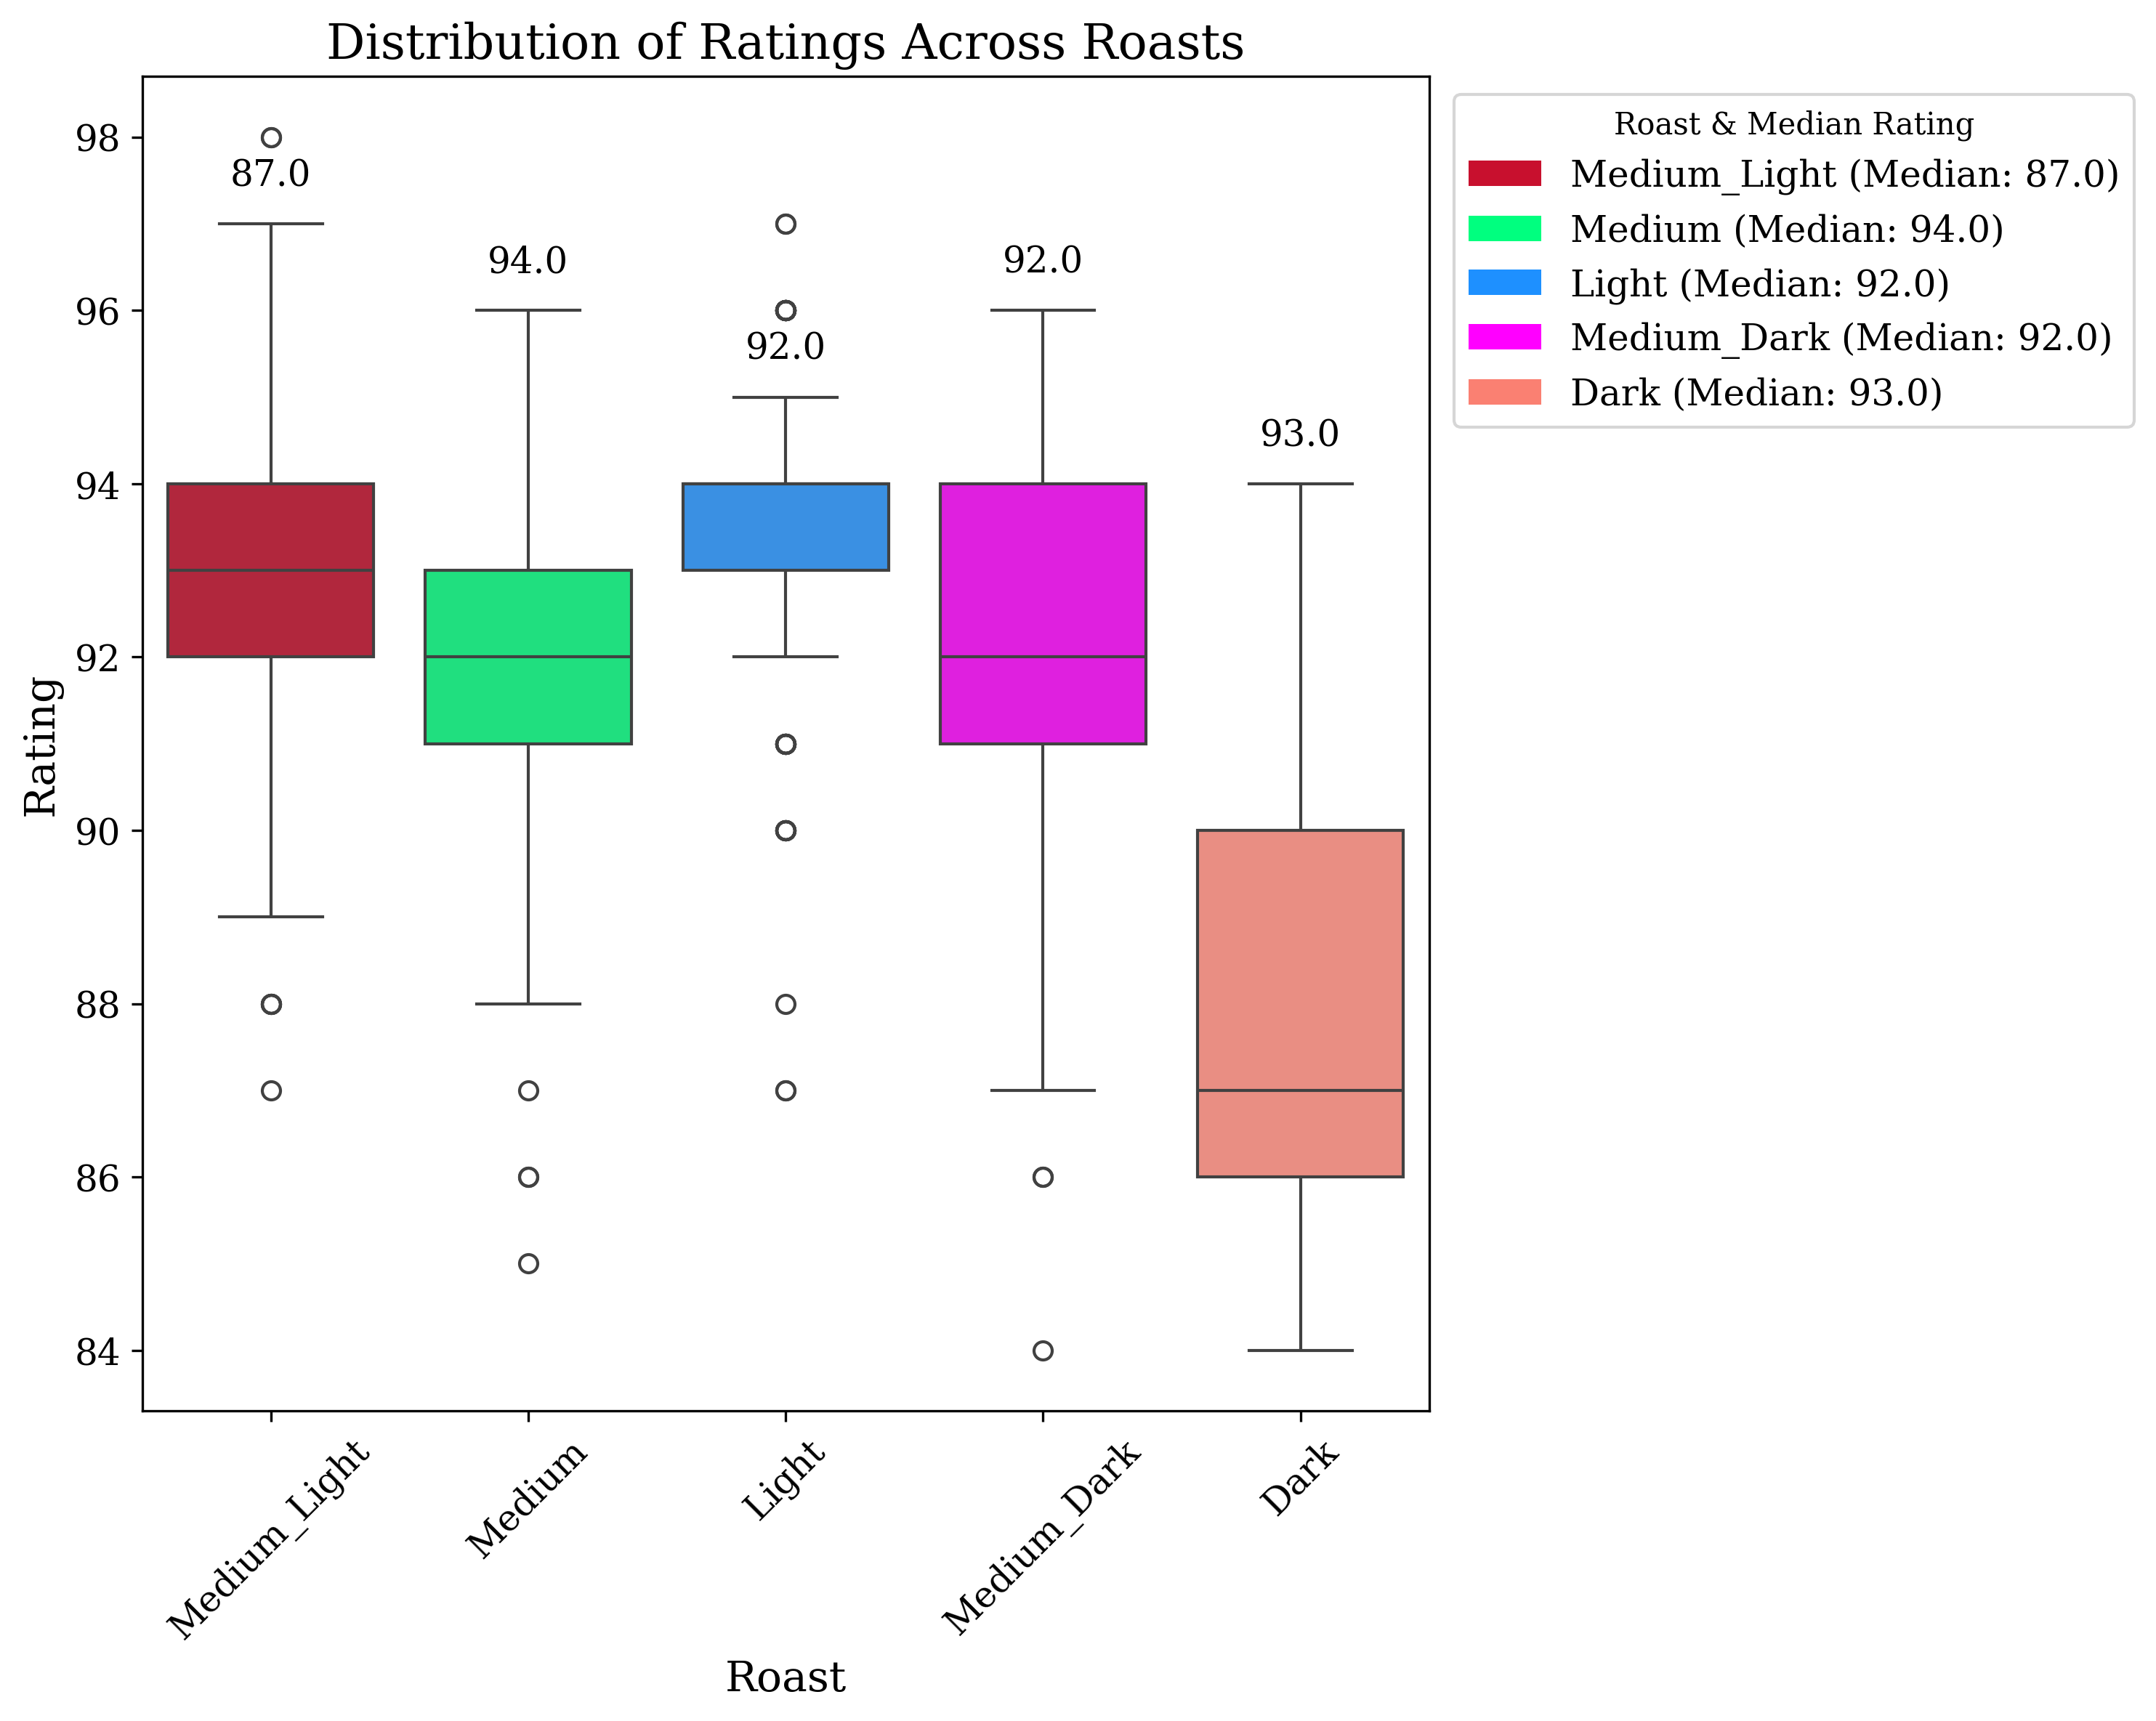

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Set the font to serif (default available font)
plt.rcParams['font.family'] = 'serif'

# Define your custom color palette (replace with your custom color hex codes)
custom_palette = ['#C8102E', 'springgreen', 'dodgerblue', 'magenta', 'salmon']  # Example palette

# Increase DPI to reduce blurriness
plt.figure(figsize=(10, 8), dpi=300)  # Adjust figsize and dpi as needed

# Create the boxplot with customizations and ensure hue is None
ax = sns.boxplot(data=vader_copy, x='roast', y='rating', palette=custom_palette, hue=None)

# Calculate median values for each roast
medians = vader_copy.groupby(['roast'])['rating'].median().values

# Add numerical annotations (at the top of each box)
for i, median in enumerate(medians):
    upper_whisker = ax.lines[1 + i * 6].get_ydata()[1]  # Get the y-value of the upper whisker
    ax.annotate(f'{median:.1f}', xy=(i, upper_whisker),
                xytext=(0, 10), textcoords='offset points',
                ha='center', va='bottom', fontsize=12)

# Create color patches for the legend based on the custom palette
legend_labels = [f'{label} (Median: {median:.1f})' for label, median in zip(['Medium_Light', 'Medium', 'Light', 'Medium_Dark', 'Dark'], medians)]
legend_colors = custom_palette
handles = [Patch(facecolor=color, label=label) for color, label in zip(legend_colors, legend_labels)]

# Adjust the legend to prevent overlap
plt.legend(handles=handles, title='Roast & Median Rating', loc='upper left', bbox_to_anchor=(1.005, 1), fontsize=12)

# Customize the title, axis labels, and ticks
plt.title('Distribution of Ratings Across Roasts', fontsize=16)
plt.xlabel('Roast', fontsize=14)
plt.ylabel('Rating', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()


<ipython-input-37-fc94cafd20dd>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=vader_copy, x='roast', y='compound_scaled_1_10', palette=custom_palette_sentiment)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need t

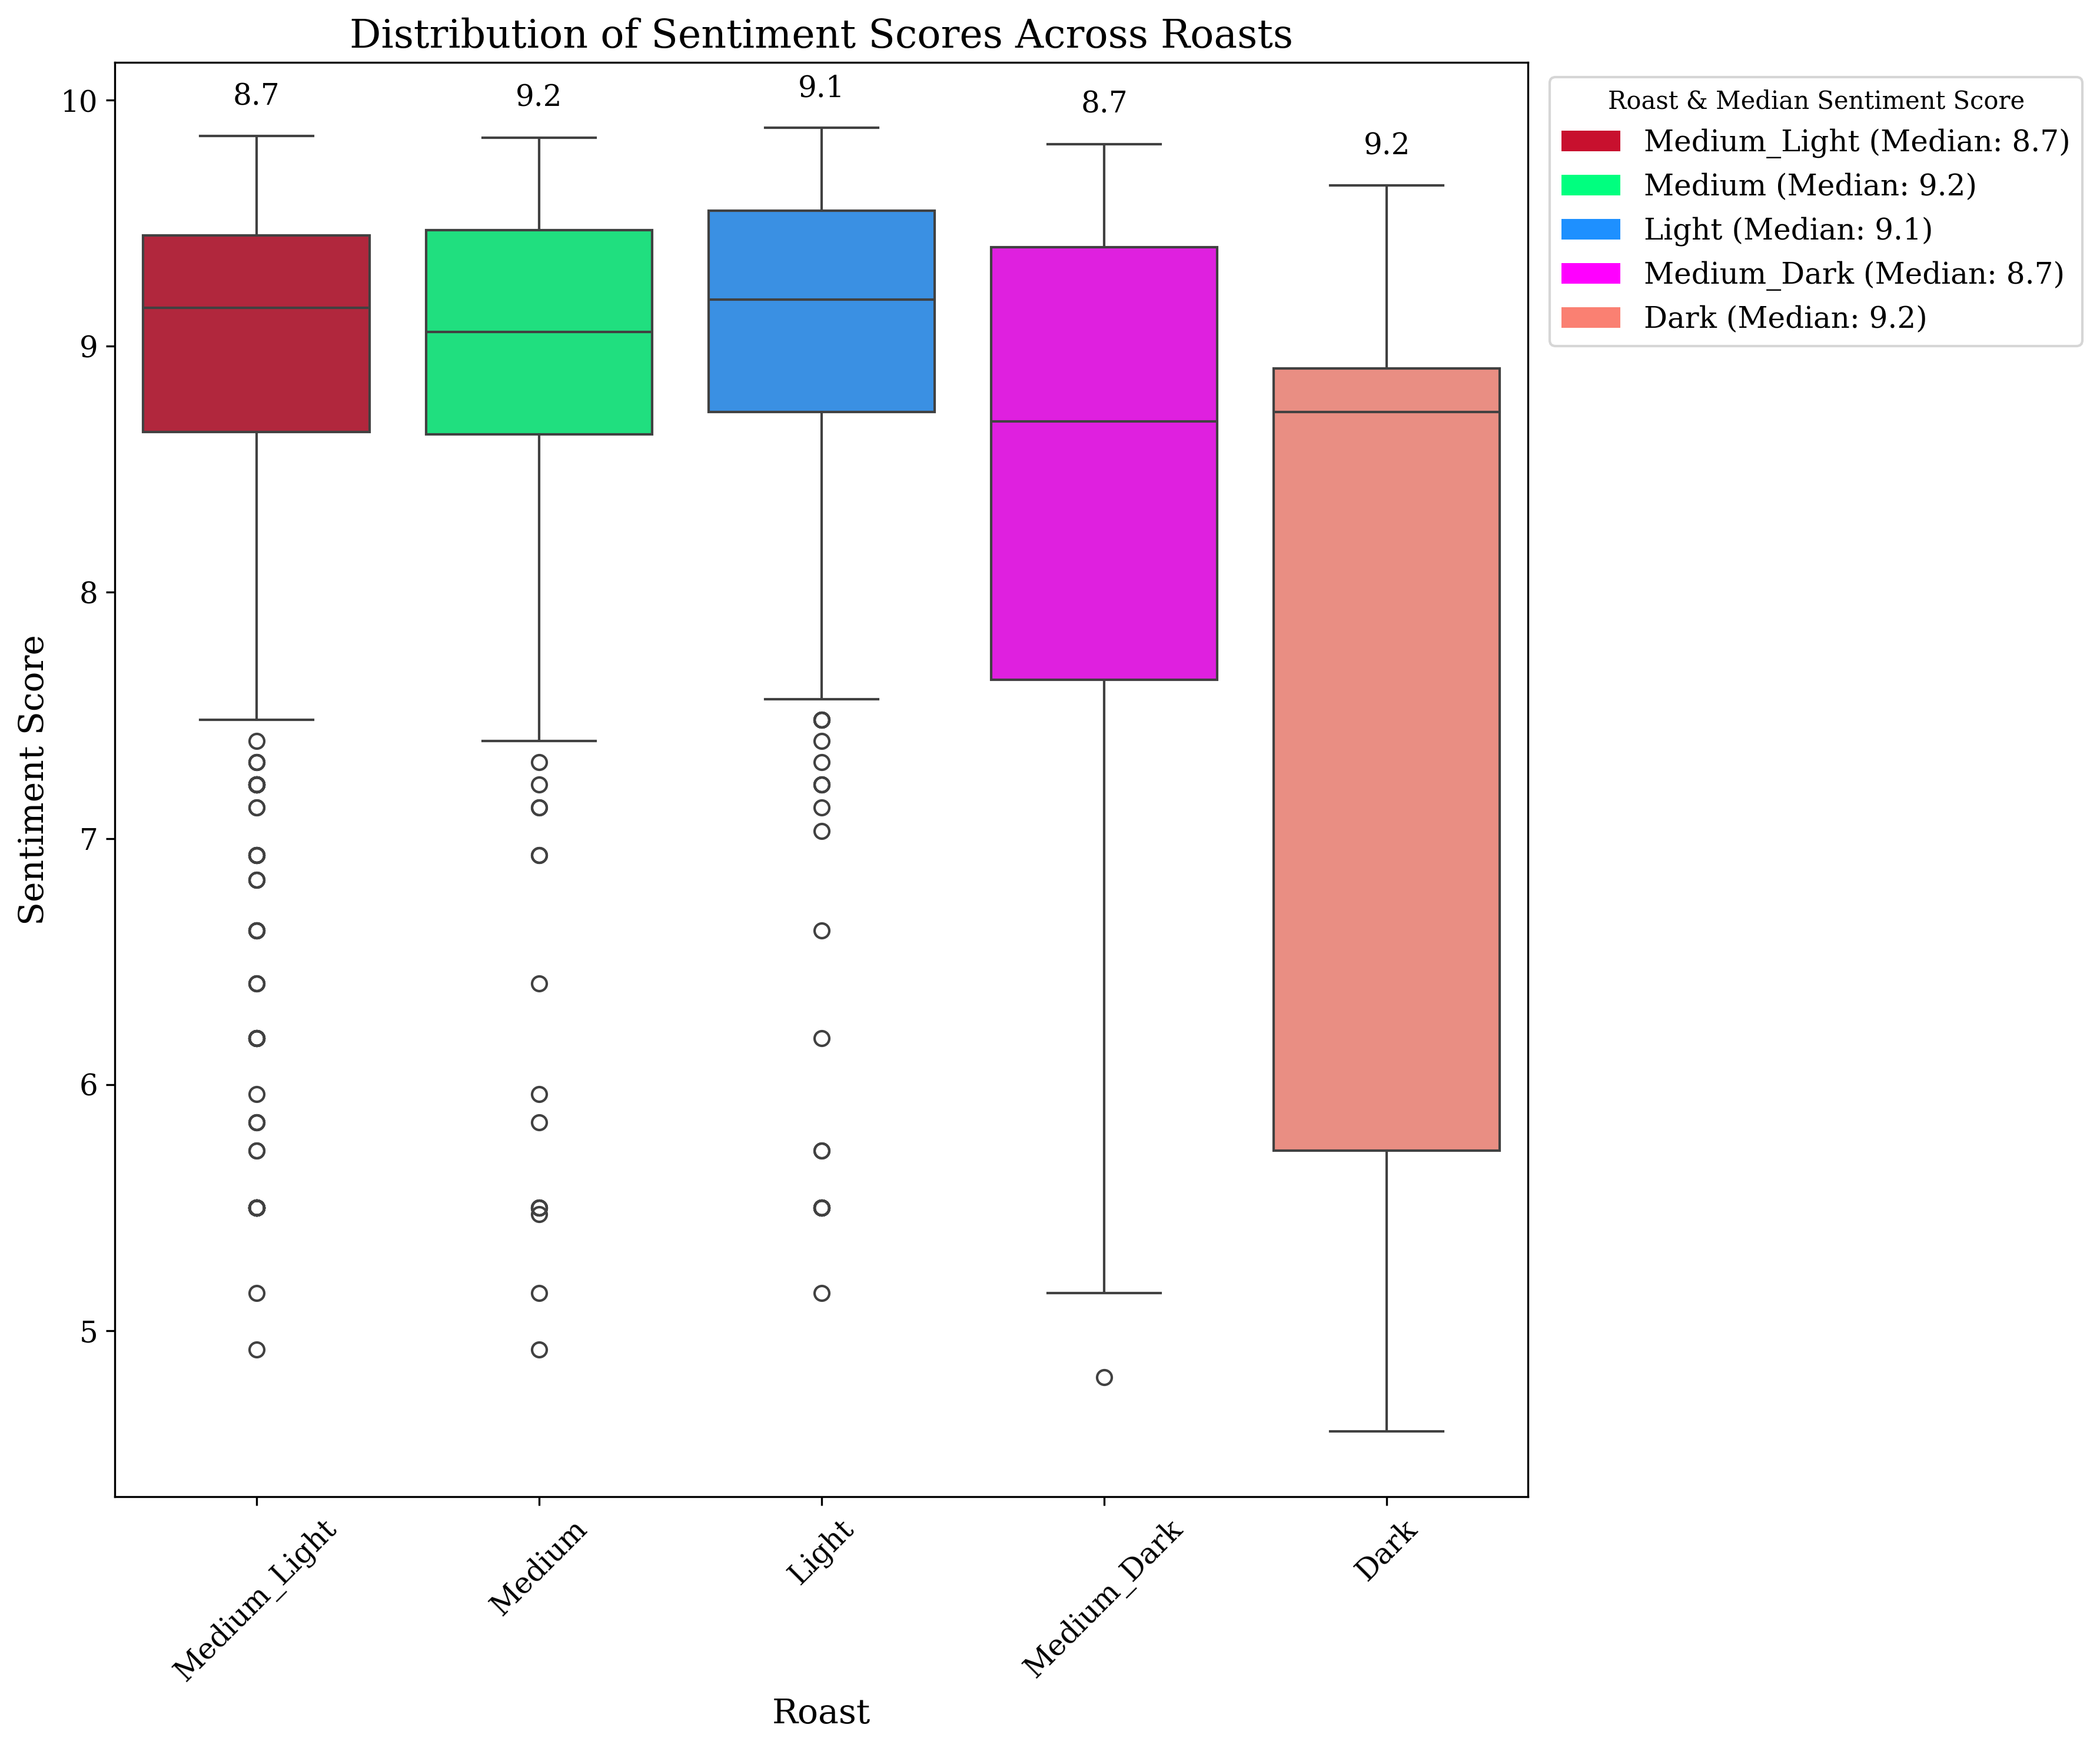

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Set the font to serif (default available font)
plt.rcParams['font.family'] = 'serif'

# Define your custom color palette (replace with your custom color hex codes)
custom_palette_sentiment = ['#C8102E', 'springgreen', 'dodgerblue', 'magenta', 'salmon']  # Example palette

# Increase DPI and figure size to make it more readable
plt.figure(figsize=(12, 10), dpi=300)  # Larger figure size for better visibility

# Create the boxplot for sentiment scores
ax = sns.boxplot(data=vader_copy, x='roast', y='compound_scaled_1_10', palette=custom_palette_sentiment)

# Calculate median sentiment scores for each roast
medians_sentiment = vader_copy.groupby(['roast'])['compound_scaled_1_10'].median().values

# Add numerical annotations (at the top of each box)
for i, median in enumerate(medians_sentiment):
    upper_whisker = ax.lines[1 + i * 6].get_ydata()[1]  # Get the y-value of the upper whisker
    ax.annotate(f'{median:.1f}', xy=(i, upper_whisker),
                xytext=(0, 10), textcoords='offset points',
                ha='center', va='bottom', fontsize=12)

# Create color patches for the legend based on the custom palette
legend_labels_sentiment = [f'{label} (Median: {median:.1f})' for label, median in zip(['Medium_Light', 'Medium', 'Light', 'Medium_Dark', 'Dark'], medians_sentiment)]
legend_colors_sentiment = custom_palette_sentiment
handles_sentiment = [Patch(facecolor=color, label=label) for color, label in zip(legend_colors_sentiment, legend_labels_sentiment)]

# Adjust the legend to prevent overlap
plt.legend(handles=handles_sentiment, title='Roast & Median Sentiment Score', loc='upper left', bbox_to_anchor=(1.005, 1), fontsize=12)

# Customize the title, axis labels, and ticks
plt.title('Distribution of Sentiment Scores Across Roasts', fontsize=16)
plt.xlabel('Roast', fontsize=14)
plt.ylabel('Sentiment Score', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()


<ipython-input-38-53a069282d94>:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(data=vader_copy, x='roast', y='rating', palette=custom_palette_rating, estimator=np.mean, ci=None)
<ipython-input-38-53a069282d94>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=vader_copy, x='roast', y='rating', palette=custom_palette_rating, estimator=np.mean, ci=None)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 lis

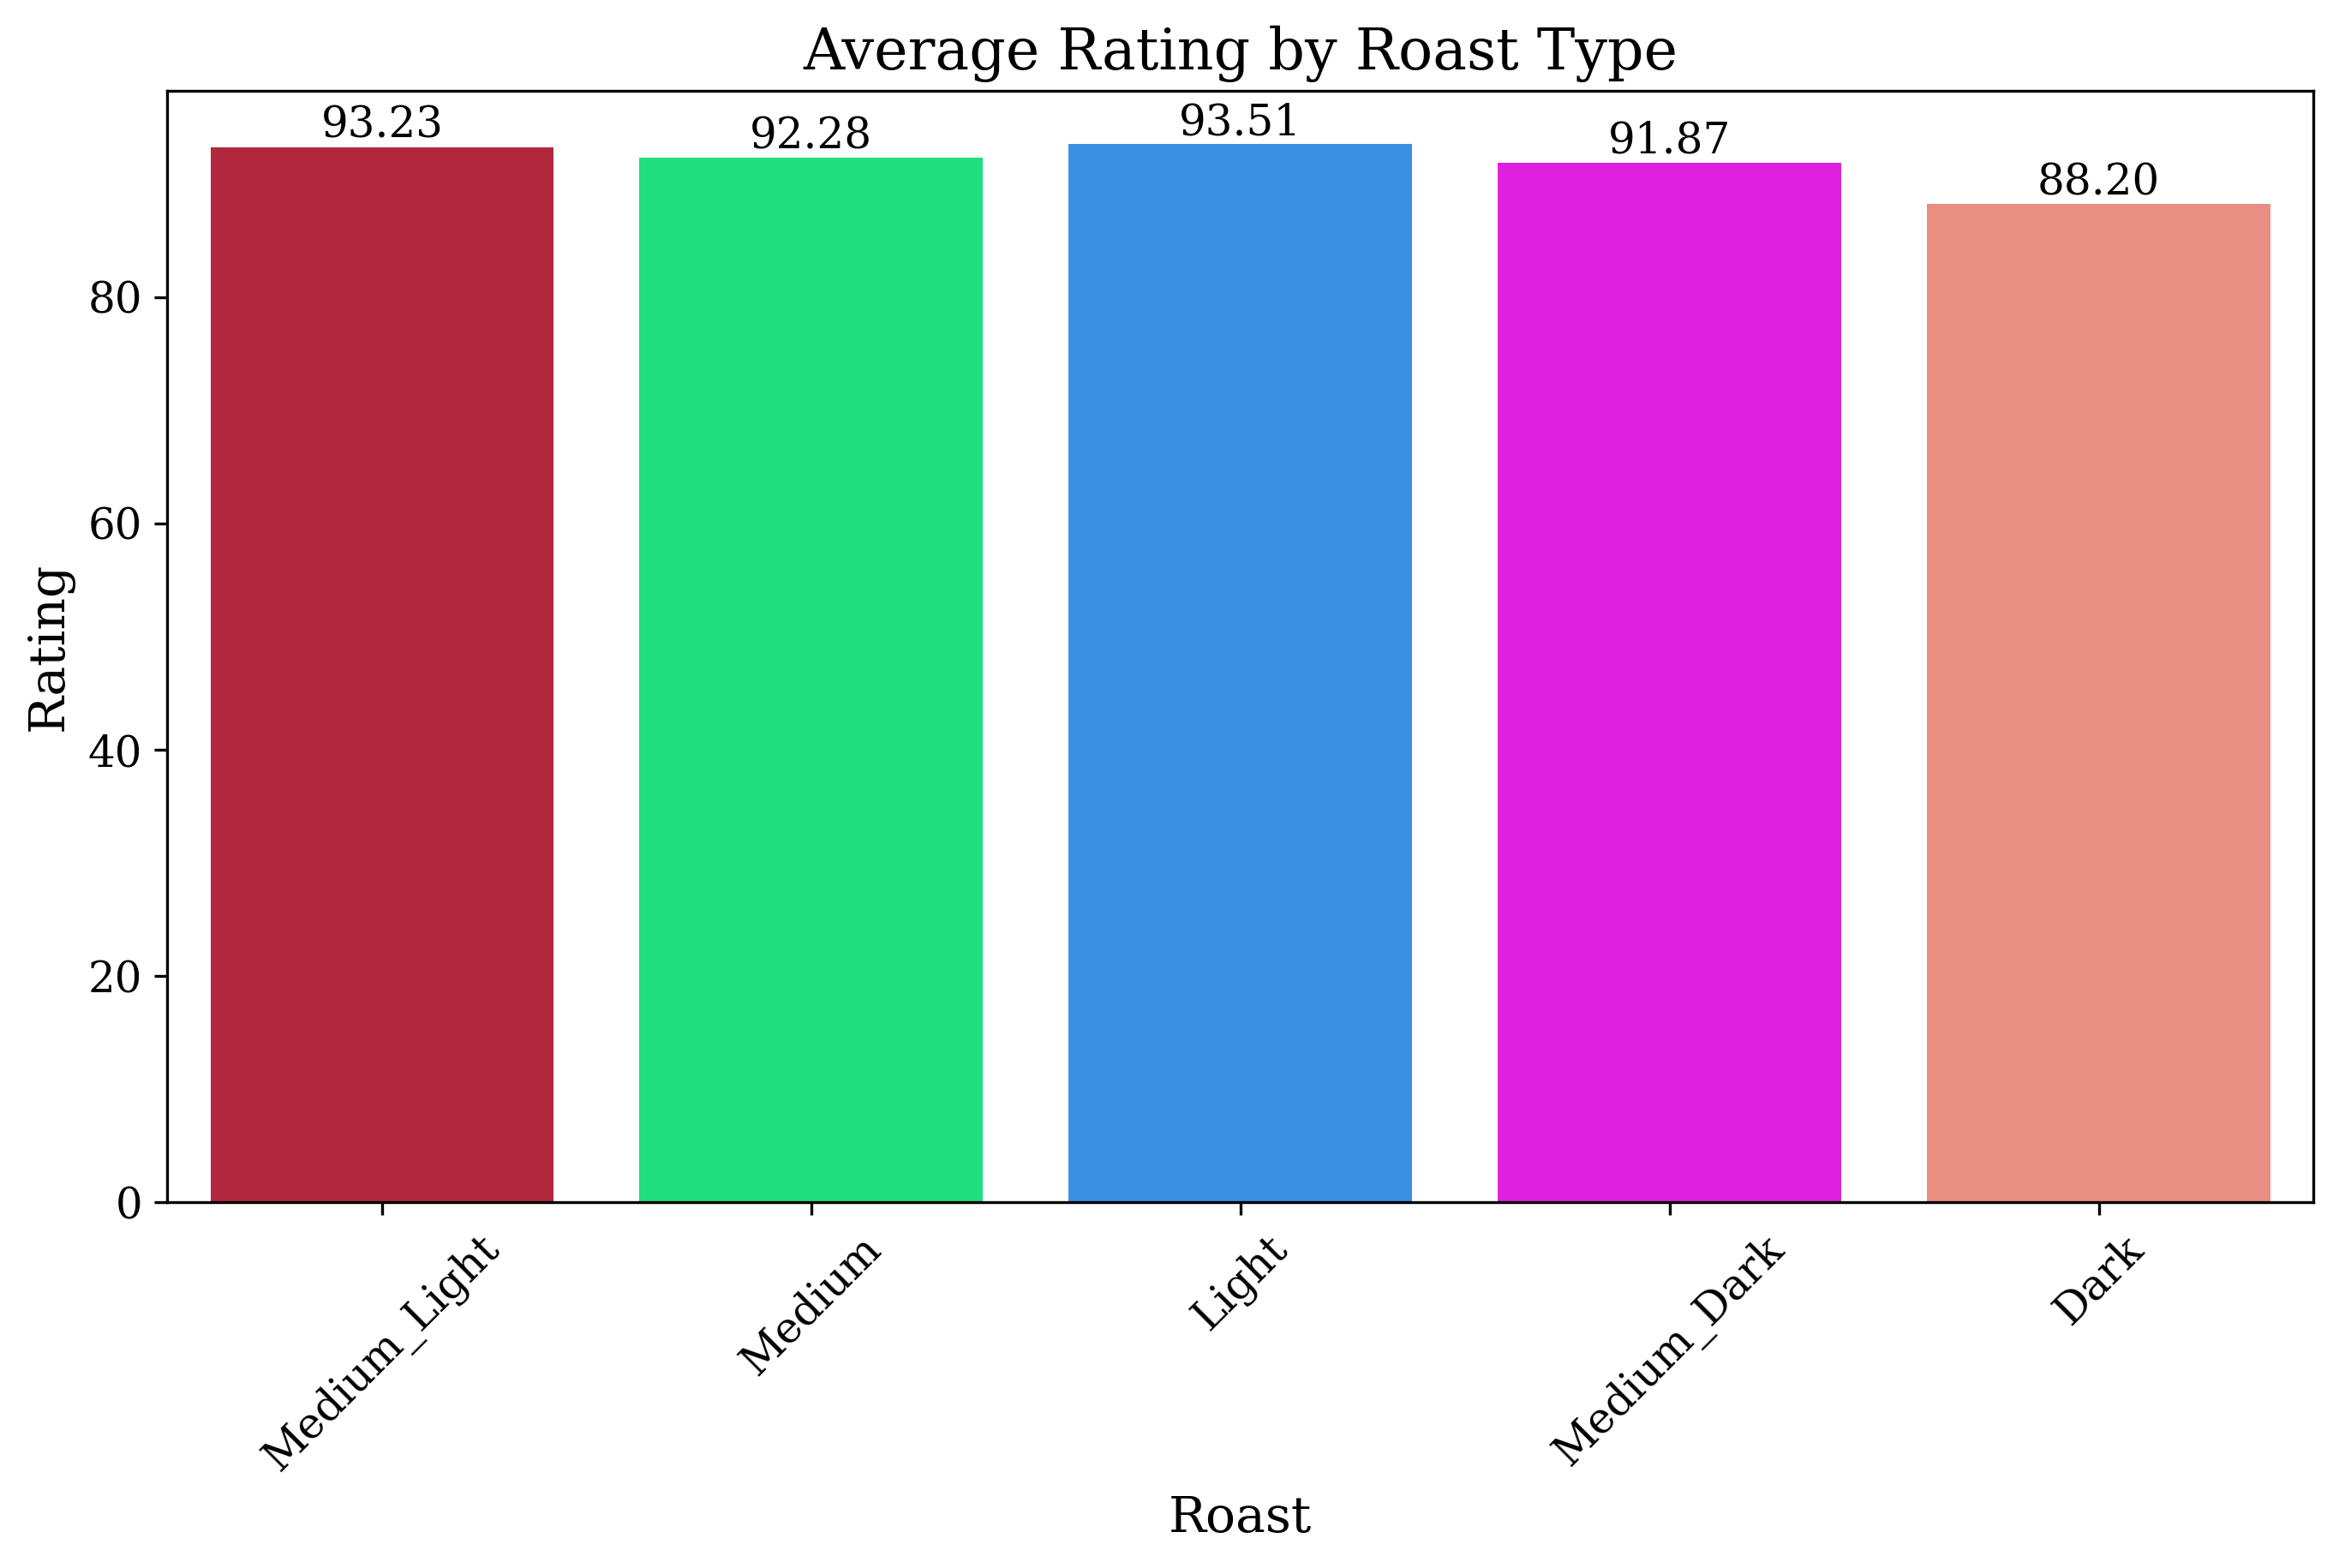

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define a custom color palette for bar plot
custom_palette_rating = ['#C8102E', 'springgreen', 'dodgerblue', 'magenta', 'salmon']  # Replace with your colors

# Increase DPI and adjust the figure size
plt.figure(figsize=(9.2, 6.2), dpi=300)  # Adjusted figure size

# Create the bar plot for average rating by roast without error bars (ci=None)
ax = sns.barplot(data=vader_copy, x='roast', y='rating', palette=custom_palette_rating, estimator=np.mean, ci=None)

# Add numerical values to the top of each bar
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2,     # X coordinate: center of each bar
            p.get_height(),                    # Y coordinate: height of the bar
            f'{p.get_height():.2f}',           # Format the height value to 2 decimal places
            ha='center', va='bottom',          # Align text horizontally and vertically
            fontsize=12)                       # Font size for the text

# Customize title and labels
plt.title('Average Rating by Roast Type', fontsize=16)
plt.xlabel('Roast', fontsize=14)
plt.ylabel('Rating', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Display plot
plt.tight_layout()
plt.show()



<ipython-input-42-06ffb761bab5>:2: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  ax = sns.countplot(data=vader_copy, x='roast', hue='price_bucket', palette=custom_palette_rating)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to

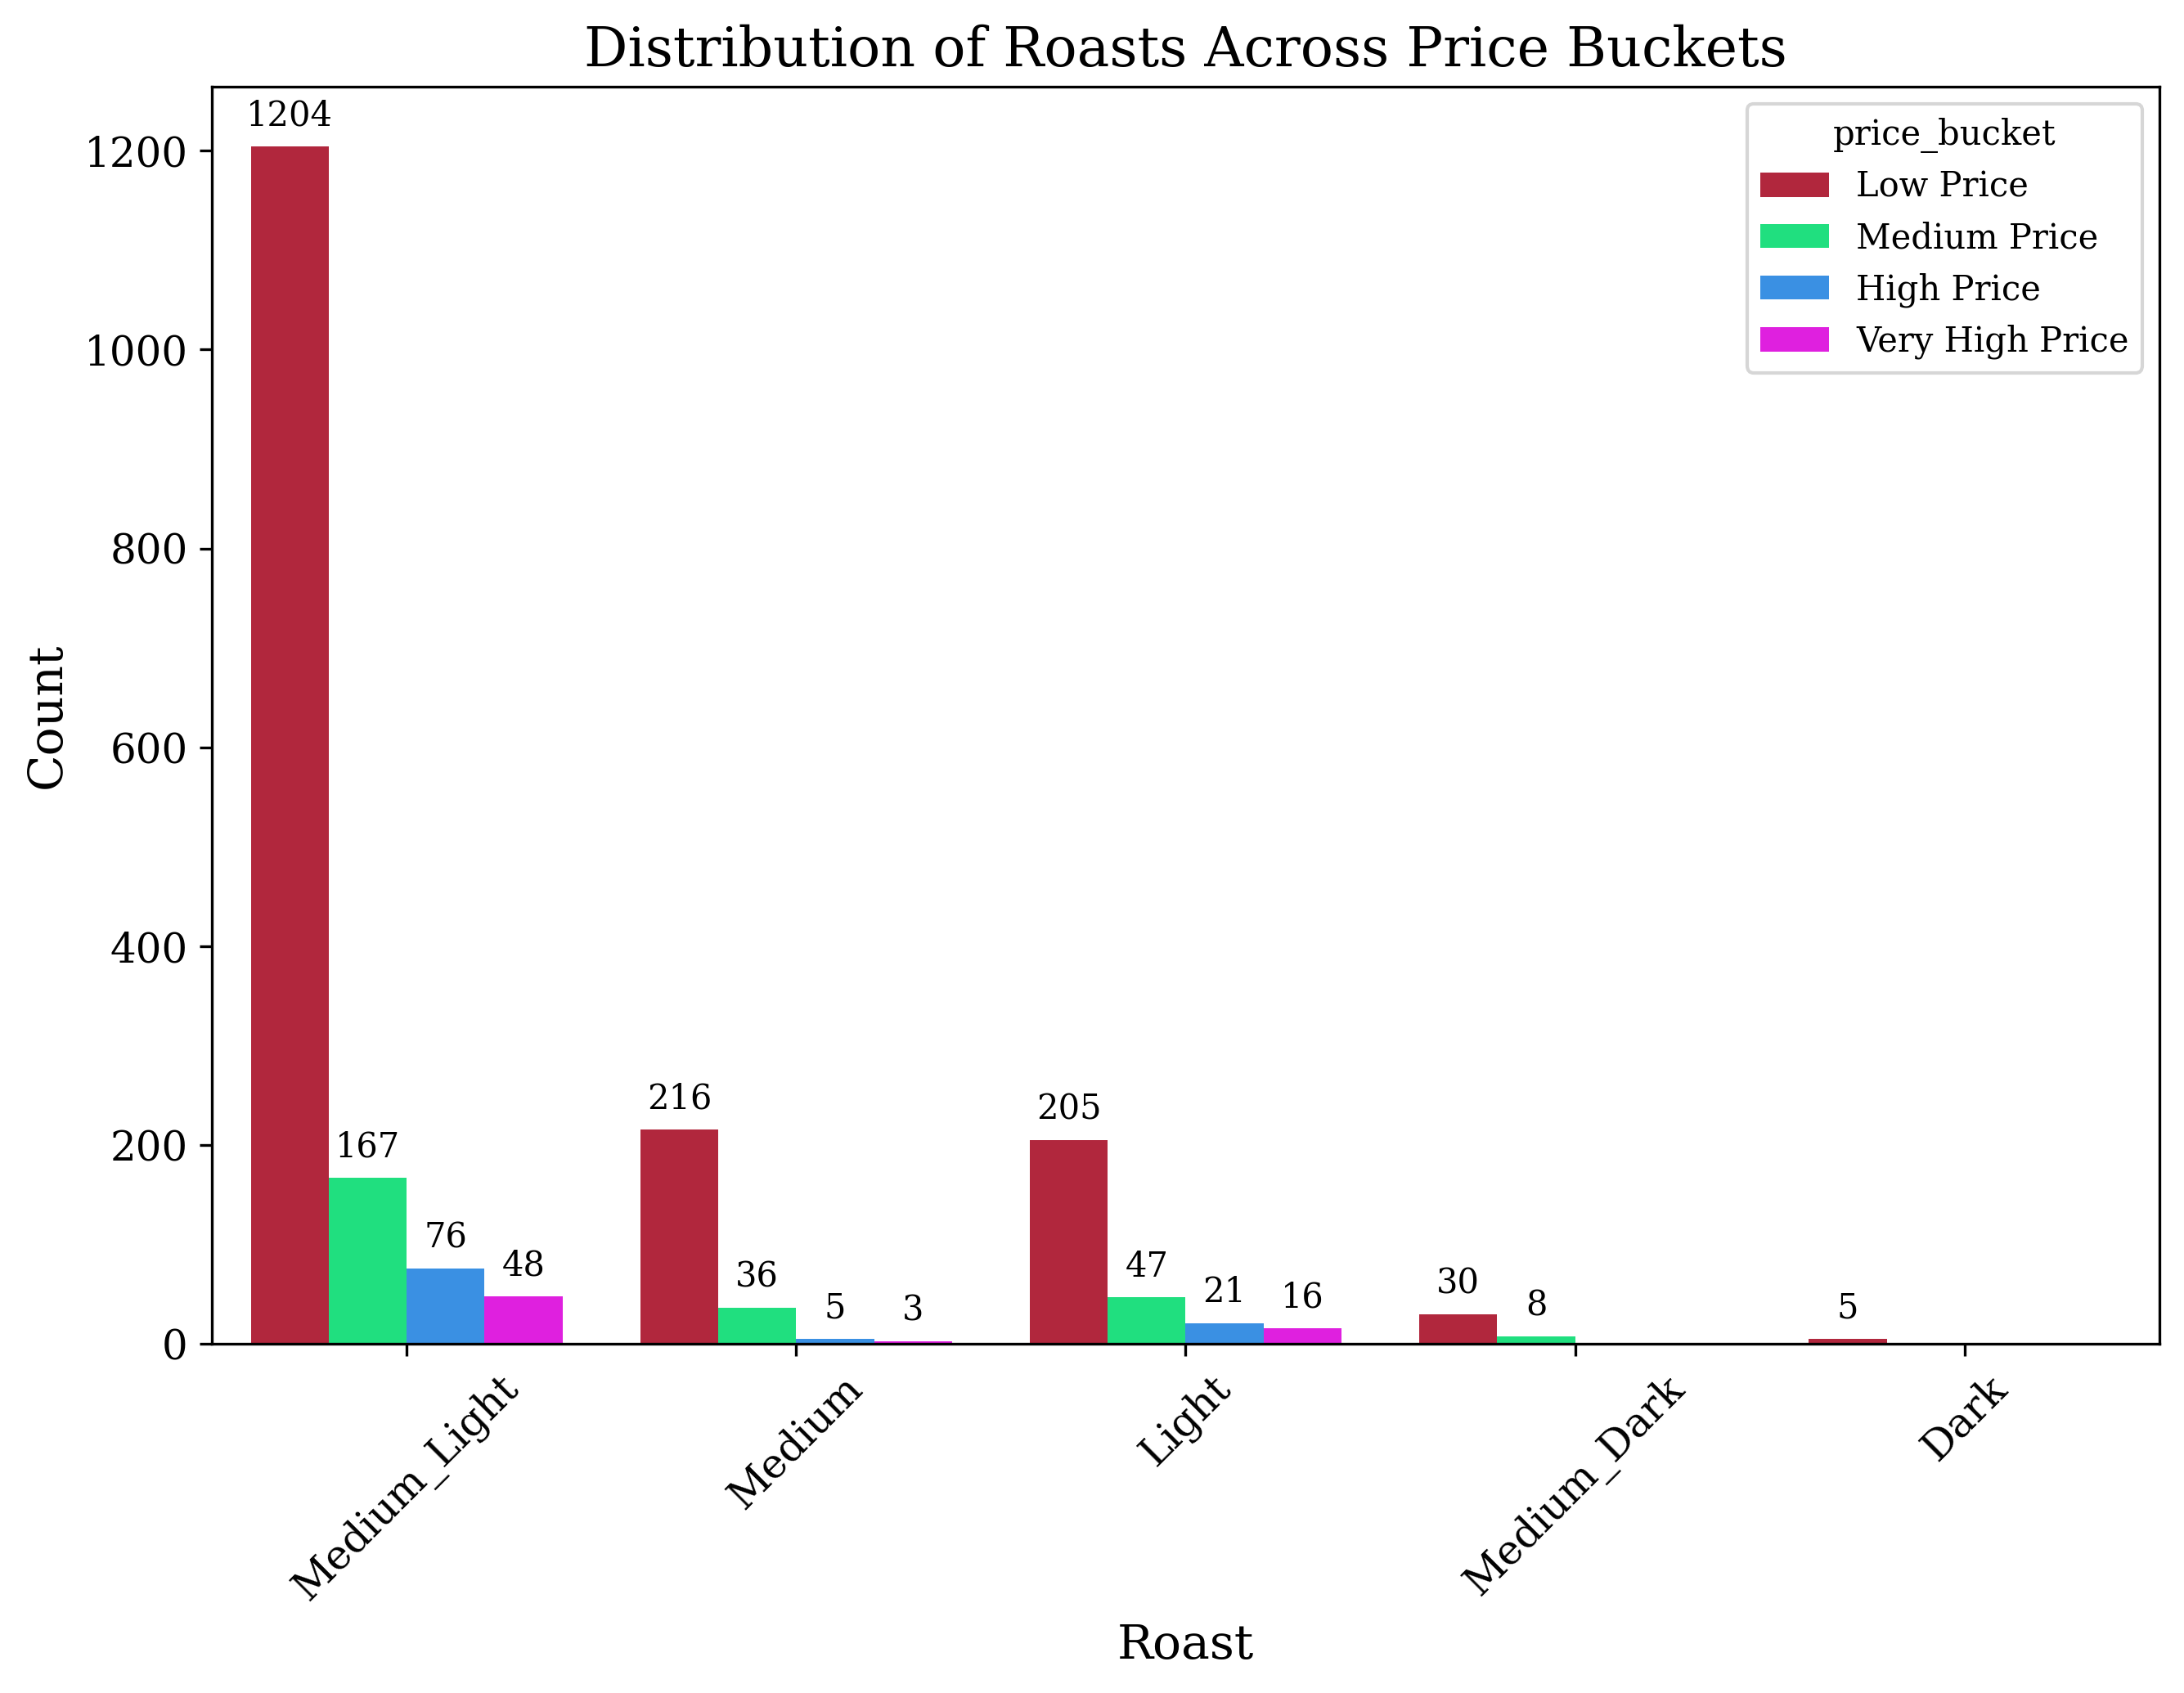

In [ ]:
plt.figure(figsize=(9, 7), dpi=300)
ax = sns.countplot(data=vader_copy, x='roast', hue='price_bucket', palette=custom_palette_rating)

# Add numerical annotations, but exclude zero values
for p in ax.patches:
    if p.get_height() > 0:  # Only annotate if height is greater than zero
        ax.annotate(format(p.get_height(), '.0f'),
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha = 'center', va = 'center',
                    xytext = (0, 9),
                    textcoords = 'offset points')

plt.title('Distribution of Roasts Across Price Buckets', fontsize=16)
plt.xlabel('Roast', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()



<ipython-input-40-a6d2708dfd65>:11: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  ax = sns.countplot(data=vader_copy, x='roast', hue='sentiment_bucket', palette=custom_palette_sentiment_buckets)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a l

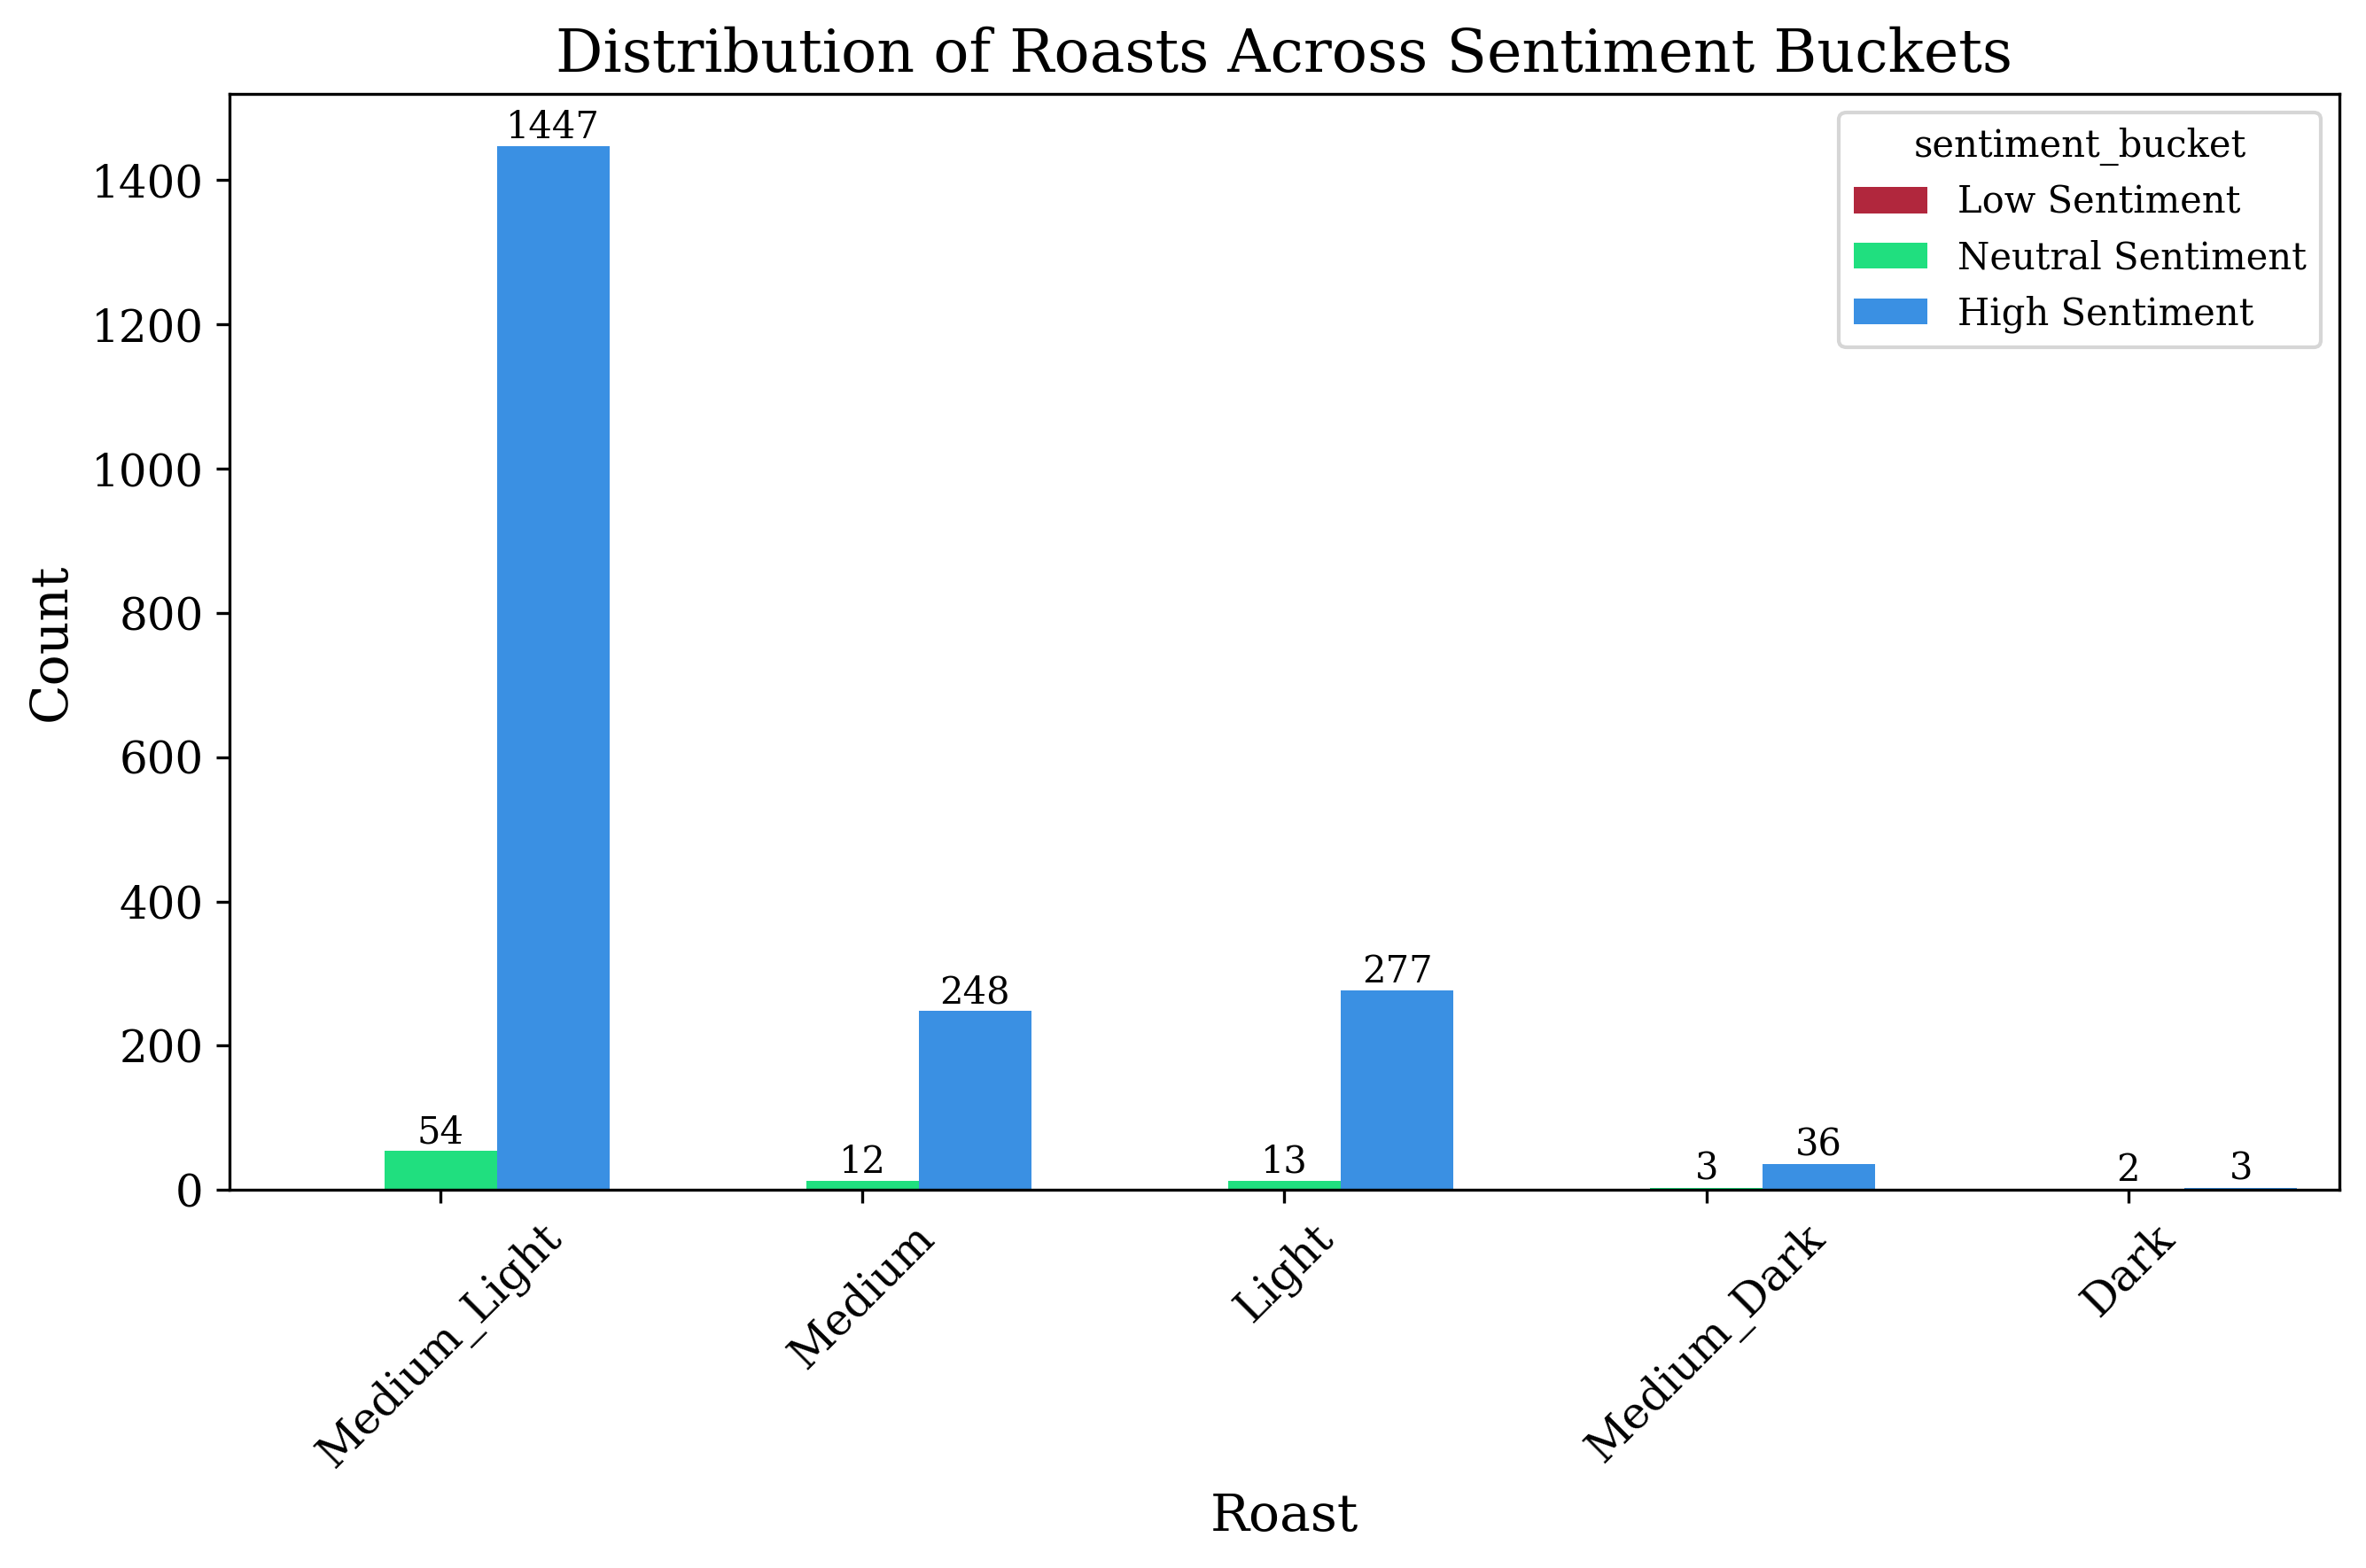

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define a custom color palette for sentiment bucket plot
custom_palette_sentiment_buckets = ['#C8102E', 'springgreen', 'dodgerblue', 'magenta', 'salmon']  # Replace with your colors

# Increase DPI and adjust the figure size
plt.figure(figsize=(9, 6), dpi=300)

# Create the countplot for sentiment buckets across roasts
ax = sns.countplot(data=vader_copy, x='roast', hue='sentiment_bucket', palette=custom_palette_sentiment_buckets)

# Add numerical values to the top of each bar
for p in ax.patches:
    height = p.get_height()
    if height > 0:  # Only add numbers if the height is greater than 0
        ax.text(p.get_x() + p.get_width() / 2, height + 0.1, f'{height:.0f}',
                ha='center', va='bottom', fontsize=10)  # Offset the text a bit higher

# Customize title and labels
plt.title('Distribution of Roasts Across Sentiment Buckets', fontsize=16)
plt.xlabel('Roast', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Display plot
plt.tight_layout()
plt.show()


In [ ]:
# Increase DPI and adjust the figure size
plt.figure(figsize=(10.5, 8.5), dpi=300)

# Create the heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)

# Customize title and labels
plt.title('Correlation Heatmap Between Rating, Sentiment, and Price', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Display plot
plt.tight_layout()
plt.show()

NameError: name 'corr' is not defined

<Figure size 3150x2550 with 0 Axes>

In [ ]:
# Summary statistics for ratings and sentiment by roast
roast_summary = vader_copy.groupby('roast')[['rating', 'compound_scaled_1_10']].mean()
print(roast_summary)